# Imports

In [1]:
#Import the necessary methods from tweepy library
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import csv
from collections import Counter
#from config import *
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import datetime

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag

import time
from collections import defaultdict
import collections
from numpy import linalg as la
import re
import math
import ast

# Loading datasets

In [2]:
data=pd.read_csv('tweet_dataset.csv')
data.text=data.text.apply(lambda x: ast.literal_eval(x))
original=pd.read_csv('originals.csv')
original.text=original.text.apply(lambda x: ast.literal_eval(x))
retweet=pd.read_csv('retweets.csv')
retweet.text=retweet.text.apply(lambda x: ast.literal_eval(x))
data.head()

,text,user,url,original_text,date,hashtags,likes,retweets
0,"[said, start, asymptomat, spread, minim, exist...",13853,https://twitter.com/Davecbb/status/13302999559...,RT @15693 Have said from the start that asympt...,Sat Nov 21 23:59:59 +0000 2020,[],0,85
1,"[subject, lockdown, amp, mental, health, partn...",83141,https://twitter.com/kraus_read/status/13302999...,RT @33133 On the subject of lockdowns &amp; me...,Sat Nov 21 23:59:59 +0000 2020,[],0,39
2,"[cannot, support, restrict, unless, govern, de...",80337,https://twitter.com/johnswansonlong/status/133...,RT @49266 ❌ We cannot support further restrict...,Sat Nov 21 23:59:59 +0000 2020,[],0,909
3,"[excel, articl, mask, evidencebas, onestopshop...",24885,https://twitter.com/JanKhan20104863/status/133...,RT @18170 Excellent article on mask evidence-b...,Sat Nov 21 23:59:59 +0000 2020,[],0,773
4,"[twice, bad, quebec, four, time, wors, ontario...",4144,https://twitter.com/AnthonyReimer/status/13302...,RT @70004 Twice as bad as Quebec. Four times w...,Sat Nov 21 23:59:59 +0000 2020,[],0,27


# Loading inverted index structures

In [3]:
def read_dict_to_file(filename):
    with open(filename, 'r') as file:
        aux = file.read()
    return json.loads(aux)

# Read index, tf and idf from files
index = read_dict_to_file('index.json')
tf = read_dict_to_file('tf.json')
idf =read_dict_to_file('idf.json')

In [4]:
punctuation = string.punctuation.replace('#','')+'…'

def preprocess_tweet(tweets_series):
    # Lowercasing text
    tweets_series = tweets_series.apply(lambda x: x.lower())

    # Remove URLS (https and www), mentions and rt
    tweets_series = tweets_series.apply(lambda x: re.sub(r'https?//\S+|www.\S+|@\w*|^rt','', x))
    
    #Removing numbers
    tweets_series=tweets_series.apply(lambda x: re.sub(r"([0-9])",'', x))

    # Remove punctuation except # (hashtags)
    tweets_series = tweets_series.apply(lambda x: "".join([char for char in x if char not in punctuation]))

    # Replacing symbol ’ for ' as they mean the same and it is needed to correctly remove stopwords
    tweets_series = tweets_series.apply(lambda x: x.replace("’","").replace('“',"").replace('”',''))
    
    #Removing emojis
    tweets_series=tweets_series.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

    # Tokenize text 
    tweets_series = tweets_series.apply(lambda x: x.split())

    # Removing stop words
    stop_words = stopwords.words('english')
    tweets_series = tweets_series.apply(lambda x: [word for word in x if word not in stop_words])
                
    # Stemming
    porter = PorterStemmer()
    tweets_series = tweets_series.apply(lambda x: [porter.stem(word) for word in x]) 

    return tweets_series

# Search Engine Build 

In [5]:
def rankDocuments(query_terms, docs, index, idf, tf, method='tf-idf'):
    """
    Perform the ranking of the results of a search based with tf-idf or popular (own score)
    
    Argument:
    query_terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    """
    global original   
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(query_terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(query_terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(query_terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    
    # HINT: use when computing tf for queryVector   
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(query_terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):  
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex]
                
    # calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:
    
    # We have two methods. 'popular' is the score with our method and otherwise it computes it with tf-idf.
    if method == 'popular':
        # Applying formula described in the report
        docScores=[ [0.4*np.dot(curDocVec, queryVector) + 0.3*np.log(original['likes'].loc[doc] + 1)/np.log(original['likes'].max() + 1) +0.3*np.log(original.retweets.loc[doc] + 1)/np.log(original.retweets.max() + 1) ,doc] for doc, curDocVec in docVectors.items() ]
    else:
        docScores=[ [np.dot(curDocVec, queryVector),doc] for doc, curDocVec in docVectors.items() ]
        
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found, try again\n")
        query = input("Insert your query:")
        resultDocs = search_tf_idf(query, index, method)    
    return resultDocs

In [6]:
def search_tf_idf(query, index, method):
    '''
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersection of them.
    '''
    query=preprocess_tweet(pd.Series(query)).values[0]

    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # Set containing docs with all query terms
            if len(docs) == 0:
                docs = docs.union(termDocs) 
            else:
                docs = docs.intersection(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, method)   

    return ranked_docs

# Creating method with Word2Vector + cosine similarity score

In [7]:
from gensim.models import Word2Vec
# Loading Word2Vector model
w2v_model = Word2Vec.load("word2vec.model")

In [8]:
def emb_vec(tweet,model=w2v_model):
    # Appending in a list the embedded representation of all the words in the tweet if they are in vocab
    query_vectors=[w2v_model.wv.word_vec(word) for word in tweet if word in w2v_model.wv.vocab]
    # In case this list of vectors have length grater than 0 we compute the average value
    if len(query_vectors)>0:
        vec=np.average(np.array(query_vectors),axis=0)
        return vec/np.linalg.norm(vec)
    # Otherwise we return a 0
    return np.zeros((1,1))

In [9]:
# Same function as emb_vec but returns the list of words that were in vocabulary
def calculate_w2v_vector(lista,model=w2v_model):
    query_vectors=[]
    for word in lista:
        if word in w2v_model.wv.vocab:
            query_vectors.append(w2v_model.wv.word_vec(word))
        else:
            lista.remove(word)
    vec=np.average(np.array(query_vectors),axis=0)
    return lista,vec/np.linalg.norm(vec)

In [10]:
def rank_docs_w2v(query_terms,query_vec, docs, index, model=w2v_model):
    global original 
    docVectors=dict() # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    # For each doc we calculate it's vector representation
    for doc in docs:
        terms=original['text'][doc]
        _,docVectors[doc]=calculate_w2v_vector(terms,model=w2v_model)
        
    # Compputing doc scores as the cosine similarity between vector representation of query and doc
    docScores=[ [np.dot(curDocVec, query_vec),doc] for doc, curDocVec in docVectors.items() ]
    # Sorting the results
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found, try again\n")
        query = input("Insert your query:")
        resultDocs = compute_w2v_rank(query, index, model=w2v_model)    
    return resultDocs

In [11]:
def compute_w2v_rank(query, index, model=w2v_model):
    '''
    output is the list of documents that contain all of the query terms. 
    So, we will get the list of documents for each query term, and take the intersection of them.
    '''
    query=preprocess_tweet(pd.Series(query)).values[0]
    lista,query_vec=calculate_w2v_vector(query,model=w2v_model)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            # Set containing docs with all query terms
            if len(docs) == 0:
                docs = docs.union(termDocs) 
            else:
                docs = docs.intersection(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rank_docs_w2v(lista,query_vec, docs, index, model=w2v_model)   
    return ranked_docs

# Choosing queries by high tf

In [12]:
high_tfidf={}
for word in tf.keys():
    high_tfidf[word]=len(tf[word])*idf[word]

In [13]:
high_tfidf=collections.OrderedDict(sorted(high_tfidf.items(), key=lambda kv: kv[1],reverse=True))
i=0
lista_words=list(high_tfidf.keys())[0:12]
queries_list=[]
for i in range(2,12):
    queries_list.append(lista_words[i%2]+' '+lista_words[i])
    print(lista_words[i%2]+' '+lista_words[i])

vaccin peopl
get test
vaccin coronaviru
get case
vaccin go
get im
vaccin like
get quarantin
vaccin dont
get new


# Storing queries output

In [18]:
with open('tfidf_queries.tsv','w', encoding='utf-8') as f:
    for query in queries_list:
        # Using tf-idf
        ranked_docs = search_tf_idf(query, index, method='tf-idf')    
        top = 20
        results_df = original.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets']]
        f.write('Query:'+query+'\n')
        f.write('=======================================\n')
        for ind, row in results_df.iterrows():
            f.write('Tweet ID: '+str(ind)+'  URL: '+str(row.url)+'\n')
            f.write('Date: '+str(row.date)+'\n')
            f.write('User: '+str(row.user)+'  Hashtags: '+str(row.hashtags)+'\n')
            f.write('Likes: '+str(row.likes)+'  Retweets: '+str(row.retweets)+'\n')
            f.write('Tweet: '+str(row.original_text)+'\n')
            f.write('=======================================\n')
        f.writelines('\n\n\n')

In [19]:
with open('new_score_queries.tsv','w', encoding='utf-8') as f:
    for query in queries_list:
        # Using our own score
        ranked_docs = search_tf_idf(query, index, method='popular')    
        top = 20
        results_df = original.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets']]
        f.write('Query:'+query+'\n')
        f.write('=======================================\n')
        for ind, row in results_df.iterrows():
            f.write('Tweet ID: '+str(ind)+'  URL: '+str(row.url)+'\n')
            f.write('Date: '+str(row.date)+'\n')
            f.write('User: '+str(row.user)+'  Hashtags: '+str(row.hashtags)+'\n')
            f.write('Likes: '+str(row.likes)+'  Retweets: '+str(row.retweets)+'\n')
            f.write('Tweet: '+str(row.original_text)+'\n')
            f.write('=======================================\n')
        f.writelines('\n\n\n')

In [20]:
with open('w2v_queries.tsv','w', encoding='utf-8') as f:
    for query in queries_list:
        # Word2Vector Score
        ranked_docs = compute_w2v_rank(query, index, model=w2v_model)
        top = 20
        results_df = original.loc[ranked_docs[:top]][['original_text','url','user','date','hashtags','likes','retweets']]
        f.write('Query:'+query+'\n')
        f.write('=======================================\n')
        for ind, row in results_df.iterrows():
            f.write('Tweet ID: '+str(ind)+'  URL: '+str(row.url)+'\n')
            f.write('Date: '+str(row.date)+'\n')
            f.write('User: '+str(row.user)+'  Hashtags: '+str(row.hashtags)+'\n')
            f.write('Likes: '+str(row.likes)+'  Retweets: '+str(row.retweets)+'\n')
            f.write('Tweet: '+str(row.original_text)+'\n')
            f.write('=======================================\n')
        f.writelines('\n\n\n')

In [21]:
# Visualize the results of the queries for each score method
filenames=['tfidf_queries.tsv','new_score_queries.tsv','w2v_queries.tsv']
with open(filenames[0],'r',encoding='utf-8') as f:
    a=f.readline()
    while(a!=''):
        print(a)
        a=f.readline()

Query:vaccin peopl


Tweet ID: 12045  URL: https://twitter.com/RockStarz_Rock/status/1331747781510356993

Date: Wed Nov 25 23:53:08 +0000 2020

User: 44581  Hashtags: []

Likes: 0  Retweets: 0

Tweet: @52921 The priority people vaccine comes in December. The rest of the vaccine in March April. Can't you people… https//t.co/1IVYpJQKb7


Tweet ID: 4780  URL: https://twitter.com/StillSombre/status/1330296672468004864

Date: Sat Nov 21 23:46:57 +0000 2020

User: 49440  Hashtags: []

Likes: 2  Retweets: 0

Tweet: I hate when people say this. People have valid reasons to be nervous about the covid vaccine. Educate people to rea… https//t.co/lK4Qy12xmc


Tweet ID: 8684  URL: https://twitter.com/agirlcalledlina/status/1330294060809138181

Date: Sat Nov 21 23:36:34 +0000 2020

User: 59177  Hashtags: []

Likes: 1  Retweets: 0

Tweet: @4797 Got to kill more people before the vaccine


Tweet ID: 6659  URL: https://twitter.com/Trish22230950/status/1330295390122414082

Date: Sat Nov 21 23:41:51 +000

# TSNE Representation

In [22]:
low_dim_embedded=np.load('tsne_output.npy')

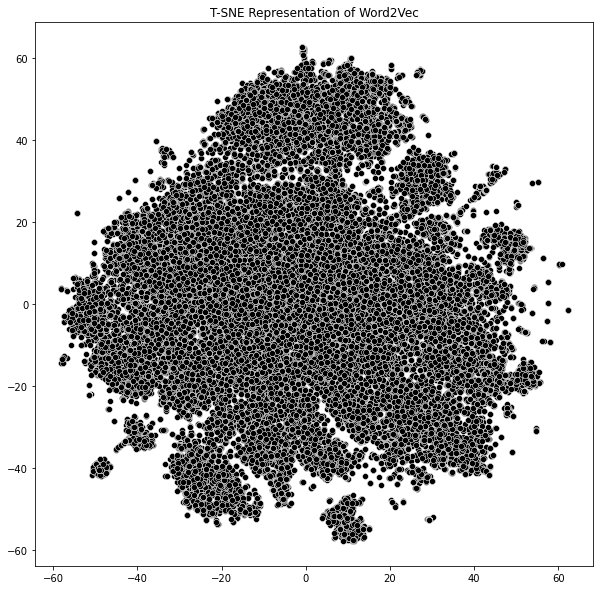

In [25]:
plt.figure(figsize=(10,10))
plt.title('T-SNE Representation of Word2Vec')
sns.scatterplot(x=low_dim_embedded[:,0],y=low_dim_embedded[:,1],color='black')
plt.show()

In [26]:
embedded_tweets=np.array([emb_vec(tweet,model=w2v_model) for tweet in original['text']])

# Clustering Representation: GMM and DBSCAN

In [33]:
from sklearn.mixture import GaussianMixture
n_clust=10
gauss=GaussianMixture(n_components=n_clust, covariance_type='full', random_state=0)
labels=gauss.fit_predict(low_dim_embedded)

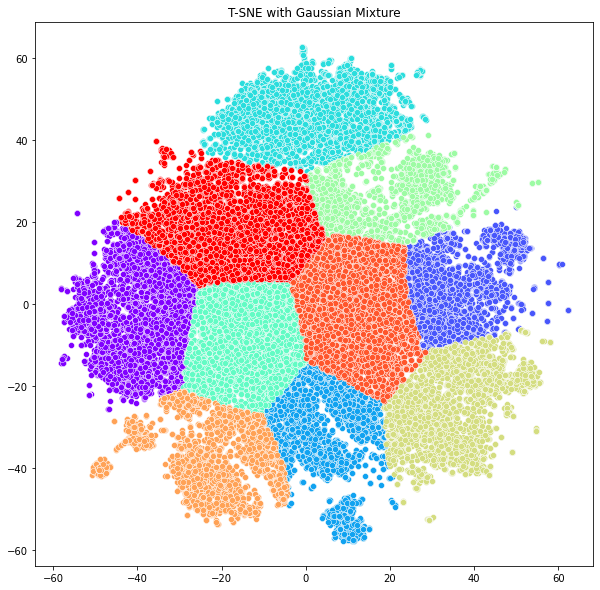

In [34]:
colors_list=cm.rainbow(np.linspace(0,1,n_clust))
plt.figure(figsize=(10,10))
plt.title('T-SNE with Gaussian Mixture')
for i in range(0,n_clust):
    sns.scatterplot(x=low_dim_embedded[labels==i,0],y=low_dim_embedded[labels==i,1],color=colors_list[i])
plt.show()

In [29]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=110).fit(low_dim_embedded)
n_clust=np.max(clustering.labels_)+1
print(n_clust)
labels=clustering.labels_

16


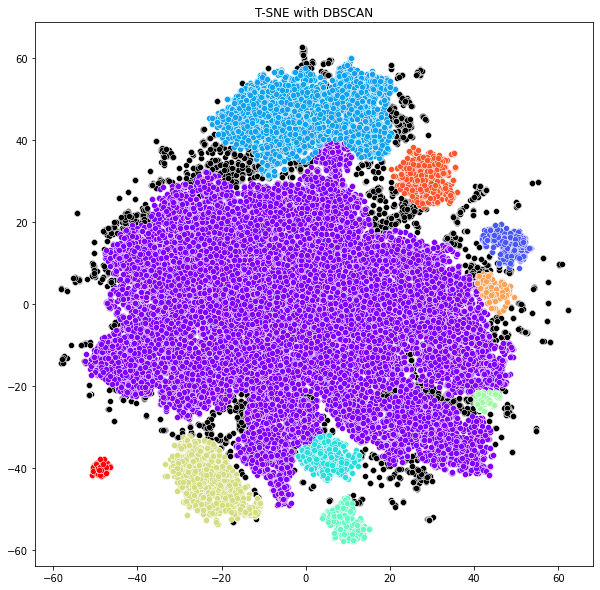

In [37]:
from matplotlib.pyplot import cm
colors_list=cm.rainbow(np.linspace(0,1,n_clust))
plt.figure(figsize=(10,10))
plt.title('T-SNE with DBSCAN')
sns.scatterplot(x=low_dim_embedded[clustering.labels_==-1,0],y=low_dim_embedded[clustering.labels_==-1,1],color='black')
for i in range(0,n_clust):
    sns.scatterplot(x=low_dim_embedded[clustering.labels_==i,0],y=low_dim_embedded[clustering.labels_==i,1],color=colors_list[i][0:3])
plt.show()

In [31]:
# Adding cluster ID to the original tweets and saving it.
original['Cluster']=labels
original.to_csv('clustering.csv',index=False)

In [38]:
# In this list we have the embedding of each word in the vocab
words_embedded=[w2v_model.wv.word_vec(word) for word in w2v_model.wv.vocab]

In [42]:
# Identify top5 topics for each cluster
for c in range(-1,n_clust):
    clust=original[original.Cluster==c]
    #Compute the cluster mean as the average of the embedded tweets in the cluster
    c_mean=np.average(embedded_tweets[original.Cluster==c],axis=0)
    # Normalizing the cluster mean
    c_mean_norm=c_mean/np.linalg.norm(c_mean)
    # Computing the cosine similarity between cluster mean and each word (normalized)
    similarity=np.array([np.dot(c_mean_norm,word)/np.linalg.norm(word) for word in words_embedded])
    print('Top 5 topics for cluster ',c,'are:')
    args=list(np.argsort(similarity)[::-1])[0:5]
    for i in range(0,5):
        print(list(w2v_model.wv.vocab.keys())[args[i]])
    print()

Top 5 topics for cluster  -1 are:
sentenc
tha
prior
label
fulli

Top 5 topics for cluster  0 are:
tha
hurt
otherwis
unfortun
hav

Top 5 topics for cluster  1 are:
#cdc
#blackfriday
price
timelin
contribut

Top 5 topics for cluster  2 are:
doubt
eventu
depend
quickli
realis

Top 5 topics for cluster  3 are:
household
worth
option
tradit
consid

Top 5 topics for cluster  4 are:
goe
cours
donni
chose
argu

Top 5 topics for cluster  5 are:
wisconsin
declin
indiana
massachusett
alarm

Top 5 topics for cluster  6 are:
te
notic
swab
phone
unfortun

Top 5 topics for cluster  7 are:
faster
cnn
sky
covi
detail

Top 5 topics for cluster  8 are:
necessari
mouth
eye
transmit
properli

Top 5 topics for cluster  9 are:
covid
coronaviru
fals
cov
whale

Top 5 topics for cluster  10 are:
bore
pictur
fun
lit
cool

Top 5 topics for cluster  11 are:
covid
te
scenario
hurt
tha

Top 5 topics for cluster  12 are:
focu
inaugur
potu
bidenharri
defeat

Top 5 topics for cluster  13 are:
overwhelm
strain
houston
i

In [43]:
# this are the keywords used to collect the data
TRACKING_KEYWORDS = ["#Covid-19","#COVID-19","covid","coronavirus","quarantine","#StayHomeStaySafe","#FlattenTheCurve","vaccine",
                     "#vaccine","#SputnikV","#Moderna","#Pfizer"]
# process the keywords
trak_key=preprocess_tweet(pd.Series(TRACKING_KEYWORDS)).apply(lambda x: x[0])
# keywords that appear in vocabulary
final_keywords=[word for word in trak_key if word in w2v_model.wv.vocab]
# embedding of keywords
key_emb=[w2v_model.wv.word_vec(word) for word in final_keywords]

# Identify top5 keywords for each cluster
for c in range(-1,n_clust):
    clust=original[original.Cluster==c]
    #Compute the cluster mean as the average of the embedded tweets in the cluster
    c_mean=np.average(embedded_tweets[original.Cluster==c],axis=0)
    # Normalizing the cluster mean
    c_mean_norm=c_mean/np.linalg.norm(c_mean)
    # Computing the cosine similarity between cluster mean and each word (normalized)
    similarity=np.array([np.dot(c_mean_norm,word)/np.linalg.norm(word) for word in key_emb])
    print('Top 5 keywords for cluster ',c,'are:')
    args=list(np.argsort(similarity)[::-1])[0:5]
    for i in range(0,5):
        print(final_keywords[args[i]])
    print()

Top 5 keywords for cluster  -1 are:
#flattenthecurv
#stayhomestaysaf
#moderna
#pfizer
covid

Top 5 keywords for cluster  0 are:
#flattenthecurv
#stayhomestaysaf
#moderna
covid
#pfizer

Top 5 keywords for cluster  1 are:
#moderna
#flattenthecurv
#stayhomestaysaf
#vaccin
#pfizer

Top 5 keywords for cluster  2 are:
#flattenthecurv
#stayhomestaysaf
#moderna
vaccin
covid

Top 5 keywords for cluster  3 are:
#flattenthecurv
#stayhomestaysaf
#moderna
covid
#pfizer

Top 5 keywords for cluster  4 are:
#flattenthecurv
#stayhomestaysaf
covid
#moderna
#pfizer

Top 5 keywords for cluster  5 are:
#moderna
#stayhomestaysaf
#flattenthecurv
#pfizer
covid

Top 5 keywords for cluster  6 are:
#flattenthecurv
covid
#stayhomestaysaf
#moderna
quarantin

Top 5 keywords for cluster  7 are:
#flattenthecurv
#stayhomestaysaf
#moderna
covid
coronaviru

Top 5 keywords for cluster  8 are:
#flattenthecurv
#stayhomestaysaf
#moderna
covid
#pfizer

Top 5 keywords for cluster  9 are:
covid
coronaviru
#moderna
#flattenthec